<a href="https://colab.research.google.com/github/cij1012/pytorch/blob/master/CNN_mydata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else 'cpu')
print('학습',device)

학습 cpu


In [0]:
torch.manual_seed(1012)
if device=='cuda':
  torch.cuda.manual_seed_all(1012)

In [4]:
kmnist_train = dsets.KMNIST(root='KMNIST_data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
kmnist_test = dsets.KMNIST(root='KMNIST_data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

Extracting KMNIST_data/KMNIST/raw/train-images-idx3-ubyte.gz to KMNIST_data/KMNIST/raw


Extracting KMNIST_data/KMNIST/raw/train-labels-idx1-ubyte.gz to KMNIST_data/KMNIST/raw



Extracting KMNIST_data/KMNIST/raw/t10k-images-idx3-ubyte.gz to KMNIST_data/KMNIST/raw


Extracting KMNIST_data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to KMNIST_data/KMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
learning_rate = 0.001
epochs = 10
batch_size = 100

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=kmnist_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=kmnist_test,
                                          batch_size=len(kmnist_test))

In [0]:
class CNN(torch.nn.Module):

  def __init__(self):
    super(CNN, self).__init__()
    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2))
  
    self.layer2 = torch.nn.Sequential(
      torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2,stride=2))

    self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

    torch.nn.init.xavier_normal_(self.fc.weight)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out

In [0]:
model = CNN().to(device)

In [0]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
total_batch = len(train_loader)
print('배치 수 : {}'.format(total_batch))

배치 수 : 600


In [11]:
plot_list = {'train' : [], 'val' :[], 'accuracy' : []}

for epoch in range(epochs):
  model.train()
  train_losses = []
  for X, Y in train_loader:
    X = X.to(device)
    Y = Y.to(device)

    optimizer.zero_grad()
    hypothesis = model(X)
    train_loss = criterion(hypothesis, Y)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.detach())
  with torch.no_grad():
    model.eval()
    val_losses = []
    for i,data in enumerate(test_loader):
      inputs, targets = data[0].to(device), data[1].to(device)

      outputs = model(inputs)
      val_loss = criterion(outputs, targets)
      val_losses.append(val_loss.detach())

      prob,label = torch.exp(outputs).topk(1,dim=1)

    correct = label.view(-1)==targets
    val_accuracy = correct.float().mean()
  print(f"{epoch+1} epoch train loss = {sum(train_losses)/len(train_losses)}")
  print(f"{epoch+1} epoch val loss = {sum(val_losses)/len(val_losses)}")
  print(f"{epoch+1} epoch accuracy = {val_accuracy}")
  print('--------------------------------------------------')
  plot_list['train'].append(sum(train_losses)/len(train_losses))
  plot_list['val'].append(sum(val_losses)/len(val_losses))
  plot_list['accuracy'].append(val_accuracy)  

1 epoch train loss = 0.39768490195274353
1 epoch val loss = 0.43913745880126953
1 epoch accuracy = 0.871399998664856
--------------------------------------------------
2 epoch train loss = 0.1474614292383194
2 epoch val loss = 0.3393191993236542
2 epoch accuracy = 0.9017999768257141
--------------------------------------------------
3 epoch train loss = 0.10503081232309341
3 epoch val loss = 0.31778937578201294
3 epoch accuracy = 0.9100000262260437
--------------------------------------------------
4 epoch train loss = 0.08137954771518707
4 epoch val loss = 0.2653895616531372
4 epoch accuracy = 0.9251000285148621
--------------------------------------------------
5 epoch train loss = 0.06450559943914413
5 epoch val loss = 0.2805623710155487
5 epoch accuracy = 0.9258999824523926
--------------------------------------------------
6 epoch train loss = 0.05073276162147522
6 epoch val loss = 0.2491893619298935
6 epoch accuracy = 0.9358999729156494
-------------------------------------------

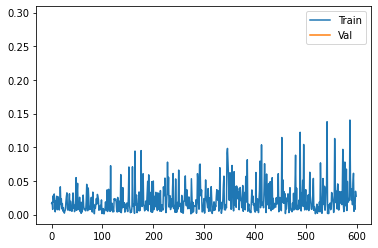

In [21]:
plt.plot(train_losses,label='Train')
plt.plot(val_losses,label='Val')
plt.legend()
plt.show()